# PyTorch neural network module

PyTorch includes the `torch.nn` module which is designed to make it easy to build neural networks. First, we will train a basic linear regression model on a toy dataset without using any features from this module. Then, we will incrementally add features from the `torch.nn` and `torch.optim` modules.

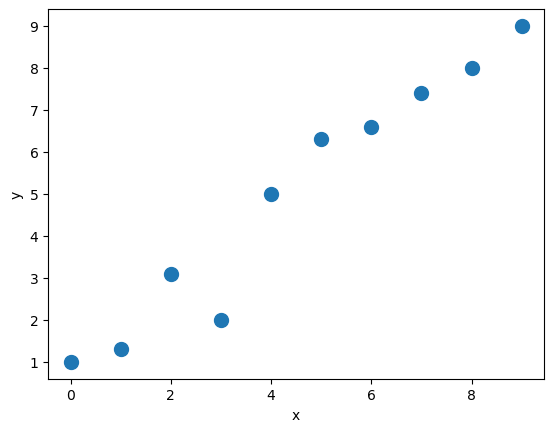

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#create a toy dataset
X_train = np.arange(10, dtype='float32').reshape(10, 1)
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0], dtype='float32')

#create plot of data
plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Next, we will standardize the features (center them about zero and divide by the standard deviation) and create a PyTorch `Dataset` for the training set and a corresponding `DataLoader`.

In [20]:
from torch.utils.data import TensorDataset, DataLoader
import torch

#standardize features (mean 0, std 1)
X_train_std = (X_train - np.mean(X_train)) / np.std(X_train)

#make X_train and y_train tensor objects
X_train_std = torch.from_numpy(X_train_std)
y_train = torch.from_numpy(y_train).float()

#create Dataset object
train_ds = TensorDataset(X_train_std, y_train)

#create DataLoader object
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

We define our linear regression model as
$$
z = wx+b,
$$
where $w$ is a weight and $b$ is a bias. We implement this in PyTorch below.

In [21]:
#initialize weight with standard normal distribution, bias with zeros
torch.manual_seed(1) #set seed for reproducibility
weight = torch.randn(1, requires_grad=True)
bias = torch.zeros(1, requires_grad=True)

#define model
def model(xb):
    return xb @ weight + bias #@ does matrix multiplication

Next, we will define the loss function that we want to minimize to find the optimal weights. We will choose the mean squared error (MSE).

In [22]:
#define MSE loss function
def loss_fn(input, target):
    return (input-target).pow(2).mean()

To learn the weight parameters of this model, we will use stochastic gradient descent. While this can be done using the `SGD` method from the `torch.optim` optimization package, we will be implmenting SGD ourselves. To compute the gradients, we will use PyTorch's `torch.autograd.backward` function for automatic differentiation.

We will set the learning rate to be $0.001$ and train the model for $200$ epochs.

In [23]:
#train the model using the batched version of the dataset
learning_rate = 0.001
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate
        weight.grad.zero_()
        bias.grad.zero_()
    if epoch % log_epochs == 0:
        print(f'Epoch: {epoch} \t Loss: {loss}')

Epoch: 0 	 Loss: 41.272491455078125
Epoch: 10 	 Loss: 24.428466796875
Epoch: 20 	 Loss: 1.057500958442688
Epoch: 30 	 Loss: 15.163039207458496
Epoch: 40 	 Loss: 12.598919868469238
Epoch: 50 	 Loss: 5.084044933319092
Epoch: 60 	 Loss: 0.7864828109741211
Epoch: 70 	 Loss: 3.7488505840301514
Epoch: 80 	 Loss: 2.4035797119140625
Epoch: 90 	 Loss: 0.44297298789024353
Epoch: 100 	 Loss: 1.115481972694397
Epoch: 110 	 Loss: 1.3195116519927979
Epoch: 120 	 Loss: 0.1064227819442749
Epoch: 130 	 Loss: 0.5676393508911133
Epoch: 140 	 Loss: 0.22158746421337128
Epoch: 150 	 Loss: 1.4862396717071533
Epoch: 160 	 Loss: 0.04833509773015976
Epoch: 170 	 Loss: 0.006100237835198641
Epoch: 180 	 Loss: 0.0015544728375971317
Epoch: 190 	 Loss: 0.029387138783931732


Final Parameters: 2.645277738571167 4.715577602386475


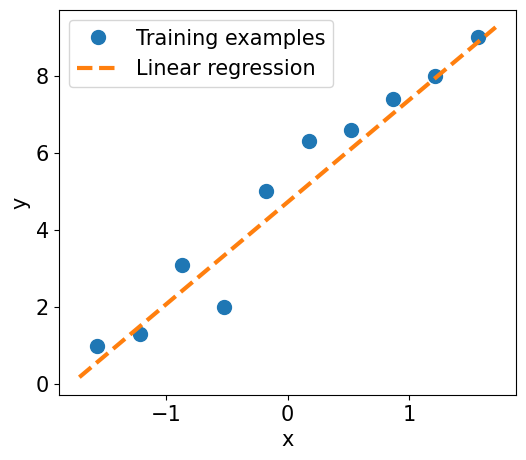

In [24]:
#look at the final parameters
print(f'Final Parameters:', weight.item(), bias.item())

#create test data and standardize it (as we did the training data)
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_std = (X_test - np.mean(X_test)) / np.std(X_test)
X_test_std = torch.from_numpy(X_test_std)

#predict the test data using the trained model
y_pred = model(X_test_std).detach().numpy()

#plot test data and training data to visualize fit
fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_std, y_train, 'o', markersize=10)
plt.plot(X_test_std, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear regression'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

# Model training with torch.nn and torch.optim modules

Instead of writing the loss function and gradient updates manually, we can make the process much less verbose using PyTorch. The `torch.nn` module provides a set of loss functions, and the `torch.optim` module supports many common optimization functions that can be called to update the parameters based on the computed gradients. Below, we define a model consisting of a single linear layer using the `torch.nn.Linear` function. We also define a stochastic gradient descent optimizer using the `torch.optim.SGD` function.

In [25]:
import torch.nn as nn

#define loss function
loss_fn = nn.MSELoss(reduction='mean')

#define model
input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size)

#define SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now, we can simply call the `step()` method of the optimizer to train the model. We can pass the batched dataset `train_dl` which we created above.

In [26]:
#train the model
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        #generate predictions
        pred = model(x_batch)[:, 0]
        
        #calculate loss
        loss = loss_fn(pred, y_batch)
        
        #compute gradient
        loss.backward()
        
        #update parameters using gradients
        optimizer.step()
        
        #reset the gradients to zero
        optimizer.zero_grad()
    if epoch % log_epochs == 0:
        print(f'Epoch: {epoch} \t Loss: {loss.item():.4f}')

Epoch: 0 	 Loss: 24.6684
Epoch: 10 	 Loss: 29.1377
Epoch: 20 	 Loss: 20.9207
Epoch: 30 	 Loss: 0.1257
Epoch: 40 	 Loss: 12.4922
Epoch: 50 	 Loss: 1.7845
Epoch: 60 	 Loss: 7.6425
Epoch: 70 	 Loss: 2.5606
Epoch: 80 	 Loss: 0.0157
Epoch: 90 	 Loss: 0.7548
Epoch: 100 	 Loss: 0.8412
Epoch: 110 	 Loss: 0.4923
Epoch: 120 	 Loss: 0.0823
Epoch: 130 	 Loss: 0.0794
Epoch: 140 	 Loss: 0.0891
Epoch: 150 	 Loss: 0.0973
Epoch: 160 	 Loss: 0.1043
Epoch: 170 	 Loss: 0.1103
Epoch: 180 	 Loss: 0.0009
Epoch: 190 	 Loss: 0.0764


In [27]:
#check that the parameters are similar to the ones from the previous method
print(f'Final parameters:', model.weight.item(), model.bias.item())

Final parameters: 2.6496422290802 4.87706995010376


# Building a multilayer perceptron

We want to build a model to predict the Iris dataset, which we used before when we first constructed a multi-layer perceptron.

### Loading in dataset

In [35]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

#load iris dataset
iris = load_iris()
X = iris['data']
y = iris['target']

#perform 2/3-1/3 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1./3, random_state=1)

Above, we randomly select $100$ examples for the training set and $50$ for the test set. Next, we will standardize the features and create a PyTorch `Dataset` and corresponding `DataLoader`.

In [36]:
#standardize features and create tensors for features and targets
X_train_std = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_std = torch.from_numpy(X_train_std).float()
y_train = torch.from_numpy(y_train)

#create Dataset and DataLoader
train_ds = TensorDataset(X_train_std, y_train)
torch.manual_seed(1) #set seed for reproducibility
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Above, we set the batch size to $2$ for the `DataLoader` object.

### Building and training a neural network

Now, we can use the `nn.Module` class in the `torch.nn` module to stack multiple layers and build a multi-layer neural network. We will use the `Linear` layer, which is also called a dense or fully-connected layer, and can be represented as 
$$
f(\mathbf{w}\cdot\mathbf{x}+b),
$$
where $\mathbf{x}$ is a tensor containing the input features, $\mathbf{w}$ is the weight tensor, and $b$ is the bias vector.

There is a single uniform dimensionality (rank and shape) for each of the hidden layers because each layer receives its inputs from the previous layer. We will define a model with $4$ input neurons (as there are $4$ input features), which are projected to $16$ neurons in the first hidden layer. We have exactly two identical hidden layers, followed by an output layer of $3$ neurons (as there are $3$ class labels).

In [41]:
#define the neural network model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = self.layer1(X)
        X = nn.Sigmoid()(X)
        X = self.layer2(X)
        return X

#create instance of Model with specified input_size, hidden_size, and output_size
input_size = X_train_std.shape[1]
hidden_size, output_size = 16, 3
model = Model(input_size, hidden_size, output_size)

Here, we use the sigmoid activation function for the first layer and softmax activation function for the output layer.

Next, we specify the loss function to be cross-entropy loss and the optimizer as Adam. We then train the model with a learning rate of $0.001$ for $100$ epochs.

In [43]:
#specify loss function and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train model for 100 epochs
num_epochs = 100
loss_hist = [0] * num_epochs #keep track of loss
accuracy_hist = [0] * num_epochs #keep track of accuracy

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        #generate predictions
        pred = model(x_batch)
        
        #calculate loss
        loss = loss_fn(pred, y_batch)
        
        #compute gradients
        loss.backward()
        
        #update parameters using gradients
        optimizer.step()
        
        #reset the gradients to zero
        optimizer.zero_grad()
        
        #store the training loss and training accuracy
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_accurate = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_accurate.sum()
    
    #calculate overall training loss and training accuracy on epoch
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

Now, we can print out the learning curves for training loss and training accuracy to evaluate the performance of the neural network on the training dataset.

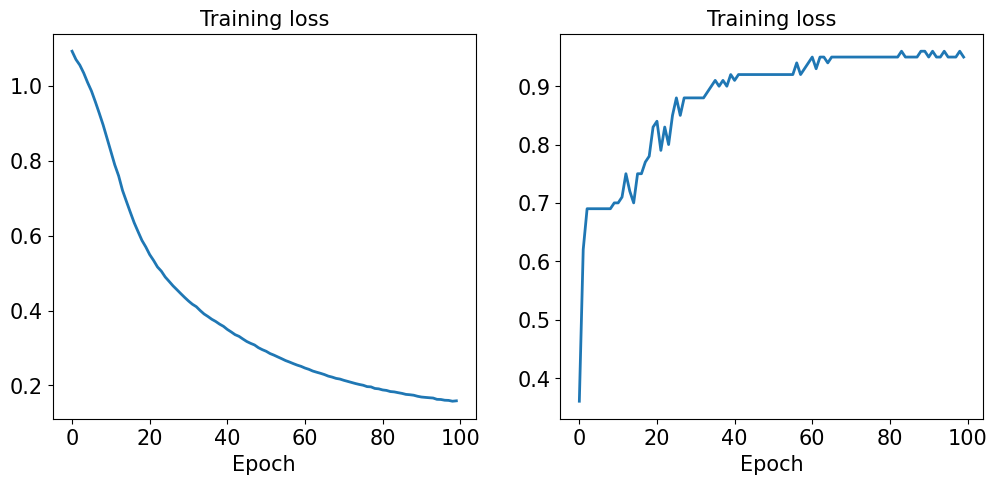

In [46]:
#set up plots
fig = plt.figure(figsize=(12, 5))

#create subplots for training loss and training accuracy
data_to_plot = [loss_hist, accuracy_hist]
for i, item in enumerate(data_to_plot):
    ax = fig.add_subplot(1, 2, i+1)
    ax.plot(item, lw=2)
    ax.set_title('Training loss', size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

From the learning curves above, we can see that the model was able to effectively learn the training set.

### Evaluating the trained model on the test set

We now evaluate the classification accuracy of the trained model on the test set.

In [47]:
#apply to the test features the same standardizing transformation that we applied to the training features
X_test_std = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_std = torch.from_numpy(X_test_std).float()
y_test = torch.from_numpy(y_test)

#predict the test set using the model we trained
test_pred = model(X_test_std)
accurate_pred = (torch.argmax(test_pred, dim=1) == y_test).float()
test_acc = accurate_pred.mean()
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.9800


We achieve a classification accuracy of $98\%$ on the test set.

### Saving and reloading the trained model

We can save the trained model on the disk for later use. Calling `torch.save(model, path)` will save both the model architecture and the weights, allowing us to easily rebuild the model and reload the parameters. 

In [51]:
#save the model
path = 'iris_classifier.pt'
torch.save(model, path)

#rebuild the model using the saved path
model_new = torch.load(path, weights_only=False)

#verify the model architecture
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

Let's evaluate this newly rebuilt model on the test set to make sure it achieves the same classification accuracy.

In [52]:
#evaluate model_new on the test set
test_pred = model(X_test_std)
accurate_pred = (torch.argmax(test_pred, dim=1) == y_test).float()
test_acc = accurate_pred.mean()
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.9800


To save only the learned parameters, use `model.state_dict()` in the place of `model`:

In [54]:
#save model parameters only
path = 'iris_classifier.pt'
torch.save(model.state_dict(), path)

#construct model and feed in saved parameters
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path, weights_only=False))

<All keys matched successfully>